In [2]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
import GPy, scipy, equality

## Equality 

In [5]:
# list of function comparisons as described in the manuscript
# functions = [[f1, f2], ...]
# f2 = None implies f2=f1

functions = \
    [[lambda x: 1, None],
     [lambda x: np.exp(x), None],
     [lambda x: np.sin(2*np.pi*x), None],
     [lambda x: 1, lambda x: 1+x],
     [lambda x: np.exp(x), lambda x: np.exp(x) + x],
     [lambda x: np.sin(2*np.pi*x), lambda x: np.sin(2*np.pi*x) + x],
     [lambda x: 1, lambda x: 1 + np.sin(2*np.pi*x)],
     [lambda x: np.exp(x), lambda x: np.exp(x) + np.sin(2*np.pi*x)],
     [lambda x: np.sin(2*np.pi*x), lambda x: 2*np.sin(2*np.pi*x)]
    ]

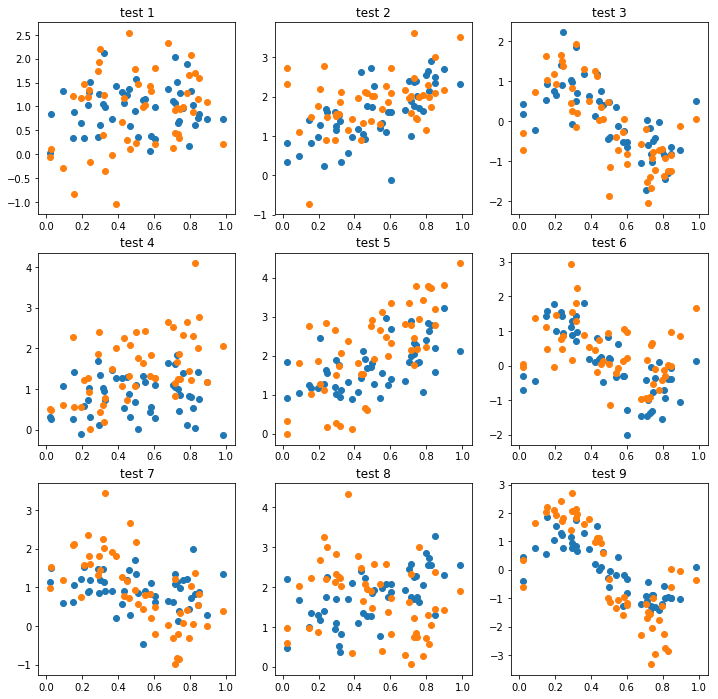

In [6]:
# examples of function outputs

n = 50
x = np.random.uniform(size=n)
sigma1 = .25
sigma2 = .5

plt.figure(figsize=(12,12))

for i, funcs in enumerate(functions):
    f1,f2 = funcs
    
    if f2 is None:
        f2 = f1
    
    plt.subplot(3,3,i+1)
    plt.title("test %d" % (i+1))
    plt.scatter(x, f1(x)+np.random.normal(scale=np.sqrt(sigma1),size=n))
    plt.scatter(x, f2(x)+np.random.normal(scale=np.sqrt(sigma2),size=n))

### Example

An example of the equality test is shown below

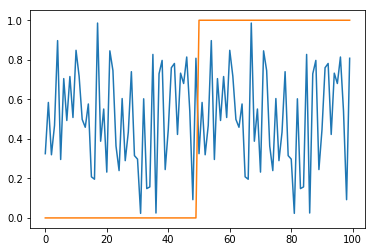

In [7]:
xgp = np.zeros((n*2, 2))
xgp[:,0] = np.tile(x,2)
xgp[n:,1] = 1

plt.plot(xgp)

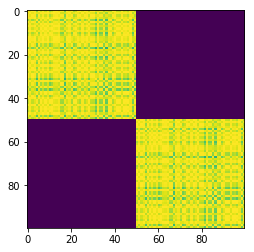

In [8]:
# independent outputs kernel allows for different functions 
# to be modeled with a shared background kernel.
#
# input is assumed to be of the form [x, index] where index
# specifies which function each observation belongs to

kern = GPy.kern.IndependentOutputs(GPy.kern.RBF(1))

plt.imshow(kern.K(xgp))

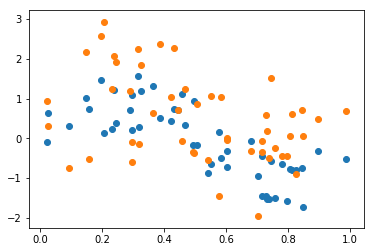

In [9]:
i = 5

f1,f2 = functions[i]

y1 = f1(x)+np.random.normal(scale=np.sqrt(sigma1),size=n)
y2 = f2(x)+np.random.normal(scale=np.sqrt(sigma2),size=n)

# input must be 2 dimensional
ygp = np.concatenate((y1,y2))[:,None]

# plt.plot(ygp)
plt.scatter(x,y1)
plt.scatter(x,y2)

In [10]:
m = GPy.models.GPRegression(xgp,ygp, kern)
m.randomize()
m

GP_regression.,value,constraints,priors
independ.rbf.variance,0.439378078119,+ve,
independ.rbf.lengthscale,1.68003820052,+ve,
Gaussian_noise.variance,1.04177499049,+ve,


In [11]:
m.optimize()
m

GP_regression.,value,constraints,priors
independ.rbf.variance,0.522000370445,+ve,
independ.rbf.lengthscale,0.223711660108,+ve,
Gaussian_noise.variance,0.562698234609,+ve,


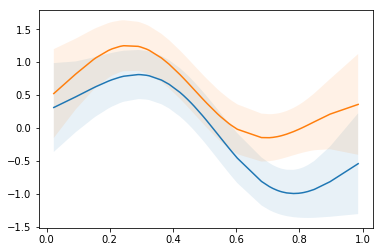

In [25]:
xpred = np.zeros((n*2,2))
xpred[:,0] = np.tile(np.sort(x),2)
xpred[n:,1] = 1

# predict noiseless to get function (not observation) intervals
mu,cov = m.predict_noiseless(xpred,full_cov=True)
std = np.sqrt(np.diagonal(cov))

plt.plot(xpred[:n,0],mu[:n,0])
plt.fill_between(xpred[:n,0],mu[:n,0]-1.98*std[:n],mu[:n,0]+1.98*std[:n],alpha=.1)

plt.plot(xpred[:n,0],mu[n:,0])
plt.fill_between(xpred[:n,0],mu[n:,0]-1.98*std[n:],mu[n:,0]+1.98*std[n:],alpha=.1)

# plt.plot(xpred[:,0],mu[:,0])

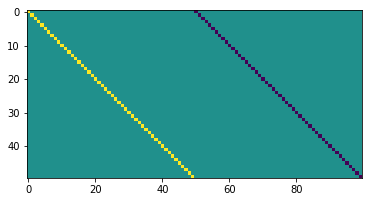

In [26]:
# we build an operation to compute the difference between f1 and f2

op = np.zeros((n,n*2))
for i in range(n):
    op[i,i] = 1
    op[i,i+n] = -1
    
plt.imshow(op)

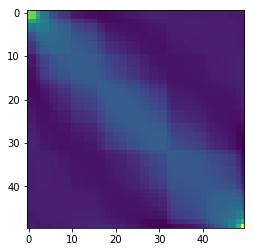

In [27]:
mu = np.dot(op,mu)
cov = np.dot(op, np.dot(cov, op.T))

In [28]:
# compute the degrees of freedom based off 
# the number of positive eigenvalues

evals = np.linalg.eigvals(cov)
nu = sum(evals > 1e-3)
nu

8

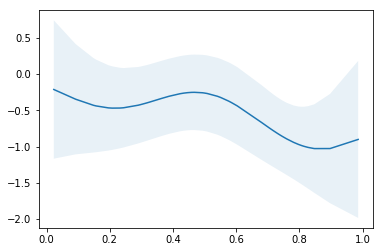

In [29]:
std = np.sqrt(np.diagonal(cov))

plt.plot(xpred[:n,0],mu[:n,0])
plt.fill_between(xpred[:n,0],mu[:n,0]-1.98*std[:n],mu[:n,0]+1.98*std[:n],alpha=.1)

In [38]:
scipy.stats.chi2.cdf(np.dot(mu[:,0], np.dot(cov, mu[:,0])), nu)

0.011264080391721887

Run the test multiple times:

In [49]:
i = 0
tests = []
for r in range(1000):
    
    f1,f2 = functions[i]
    if f2 is None:
        f2 = f1

    y1 = f1(x)+np.random.normal(scale=np.sqrt(sigma1),size=n)
    y2 = f2(x)+np.random.normal(scale=np.sqrt(sigma2),size=n)

    tests.append(equality.test(x,y1,y2))
    
tests = np.array(tests)

 /home/ptonner/dev/gp-workshop/venv/local/lib/python2.7/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square


(array([ 176.,  118.,   73.,   74.,   76.,   56.,   53.,   43.,   49.,
          36.,   47.,   42.,   40.,   29.,   20.,   22.,   18.,   15.,
           6.,    7.]),
 array([  2.28720448e-05,   4.90451816e-02,   9.80674912e-02,
          1.47089801e-01,   1.96112110e-01,   2.45134420e-01,
          2.94156730e-01,   3.43179039e-01,   3.92201349e-01,
          4.41223658e-01,   4.90245968e-01,   5.39268278e-01,
          5.88290587e-01,   6.37312897e-01,   6.86335206e-01,
          7.35357516e-01,   7.84379826e-01,   8.33402135e-01,
          8.82424445e-01,   9.31446754e-01,   9.80469064e-01]),
 <a list of 20 Patch objects>)

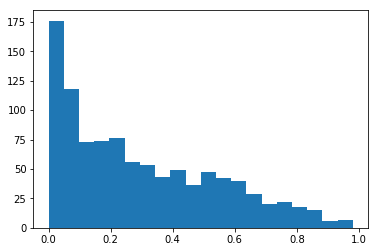

In [50]:
plt.hist(tests,20)

In [53]:
1.*sum(np.array(tests)<.95)/1000

0.996

In [55]:
tests = []

for i, funcs in enumerate(functions):
    
    print i
    
    tests.append([])
    f1,f2 = funcs
    
    if f2 is None:
        f2 = f1

    for _ in range(1000):
        y1 = f1(x)+np.random.normal(scale=np.sqrt(sigma1),size=n)
        y2 = f2(x)+np.random.normal(scale=np.sqrt(sigma2),size=n)

        tests[-1].append(equality.test(x,y1,y2))
        
    tests[-1] = np.array(tests[-1])

0
1
2
3
4
5
6
7
8


In [58]:
for i, t in enumerate(tests):
    
    f1,f2 = functions[i]
    
    if f2 is None:
        print 1.*sum(t<.95)/1000
    else:
        print 1.*sum(t>.95)/1000

0.993
0.997
1.0
0.745
0.696
0.185
0.837
0.871
0.747


(array([  17.,   14.,   18.,   18.,   32.,   18.,   23.,   26.,   23.,
          30.,   37.,   44.,   49.,   60.,   64.,   75.,   60.,   96.,
         110.,  186.]),
 array([ 0.00380758,  0.0536056 ,  0.10340362,  0.15320163,  0.20299965,
         0.25279767,  0.30259569,  0.3523937 ,  0.40219172,  0.45198974,
         0.50178776,  0.55158577,  0.60138379,  0.65118181,  0.70097982,
         0.75077784,  0.80057586,  0.85037388,  0.90017189,  0.94996991,
         0.99976793]),
 <a list of 20 Patch objects>)

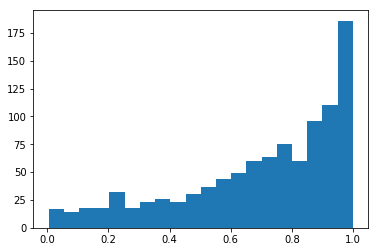

In [61]:
plt.hist(tests[-4],20)